
TODO: Coarsen the shape for analysis

- Load meshes:
  - Use DenseMaternalMeshLoader to load left hippocampus structure for all three subjects
  - TODO: Fix issue that we can't load the csv of the pilot subject!

- Create subject-specific atlases:
  - For each subject i:
    - Get pre-pregnancy meshes of left hippocampus
    - Compute subject-specific "control" deterministic atlas (mesh)

- Create global atlas:
  - Compute global pre-pregnancy control deterministic atlas from subject-specific atlases

- Extract pregnancy deformations as momenta:
  - For each subject i and pregnancy timepoint t:
    - Compute deformation between pregnancy and pre-pregnancy states: X^{pregnancy}_{it} - X_{i, pre-pregnancy} as momenta at control points
    - TODO: are the control points the same here? probably not, since they will be registered each from their subject-specific template?
    - Parallel transport deformation into global deterministic atlas space to get Xit: this is assumed to be the identity

- Build prediction model:
  - Use linear regression to predict gestational week (Yit=t) from transported deformations (Xit)

In [2]:
import pyvista as pv
from pathlib import Path

import numpy as np

from in_out.array_readers_and_writers import read_3D_array


import polpo.lddmm as lddmm
import polpo.lddmm.strings as lddmm_strings

from polpo.preprocessing.load.pregnancy import (
    DenseMaternalMeshLoader,
    DenseMaternalCsvDataLoader,
)
from polpo.preprocessing.mesh.io import PvReader, PvWriter
from polpo.preprocessing import Map, PartiallyInitializedStep
from polpo.preprocessing.mesh.registration import PvAlign


Path("results").mkdir(exist_ok=True)
OUTPUTS_DIR = Path("results") / "atlas_example"
ATLAS_DIR = OUTPUTS_DIR / "atlas"

OUTPUTS_DIR.mkdir(exist_ok=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# load meshes of all three subjects for left hipp structure using DenseMaternalMeshLoader
pipe01 = DenseMaternalMeshLoader(
    data_dir="/home/data/maternal",
    subject_id="01",
    as_dict=False,
    left=True,
    struct="Hipp",
) + Map(PvReader())

meshes01 = pipe01()

# csv01 = DenseMaternalCsvDataLoader(
#     data_dir="/home/data/maternal",
#     subject_id=None,
#     pilot=True)() 

pipe1001 = DenseMaternalMeshLoader(
    data_dir="/home/data/maternal",
    subject_id="1001",
    as_dict=False,
    left=True,
    struct="Hipp",
) + Map(PvReader())

meshes1001 = pipe1001()

csv1001 = DenseMaternalCsvDataLoader(
    data_dir="/home/data/maternal",
    subject_id="1001B")() 

pipe1004 = DenseMaternalMeshLoader(
    data_dir="/home/data/maternal",
    subject_id="1004",
    as_dict=False,
    left=True,
    struct="Hipp",
) + Map(PvReader())

meshes1004 = pipe1004()

csv1004 = DenseMaternalCsvDataLoader(
    data_dir="/home/data/maternal",
    subject_id="1004B")()

n_meshes = {
    "01": len(meshes01),
    "1001": len(meshes1001),
    "1004": len(meshes1004),
}

# for each subejct, extract the pre-pregnancy mesh
csv = {
    "01": None, #csv01,
    "1001": csv1001,
    "1004": csv1004,
}

meshes = {
    "01": meshes01,
    "1001": meshes1001,
    "1004": meshes1004,
}

print(n_meshes)

{'01': 27, '1001': 13, '1004': 21}


In [4]:
type(meshes01[0])

pyvista.core.pointset.PolyData

In [5]:
vertices = np.array(meshes01[0].points)
faces = np.array(meshes01[0].faces).reshape(-1, 4)[:, 1:]  # Remove the first column (face count)

print(vertices.shape); print(faces.shape)

(732, 3)
(1460, 3)


2025-08-27 16:45:44.278 (   6.948s) [    7FE39C5F2440]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=
/home/nmiolane/anaconda3/envs/polpo/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


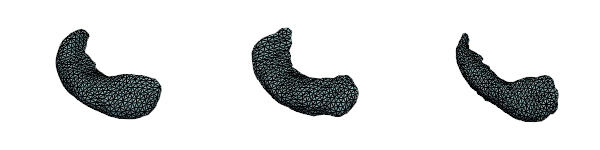

In [6]:
# Rigid alignment of all meshes to the first one of the pilot

prep_pipe = PartiallyInitializedStep(
    Step=lambda **kwargs: Map(PvAlign(**kwargs)),
    _target=lambda meshes: meshes[0],
    max_iterations=500,
)

all_meshes = prep_pipe([mesh for subject_id in ["01", "1001", "1004"] for mesh in meshes[subject_id]])

meshes = {
    "01": all_meshes[:n_meshes["01"]],
    "1001": all_meshes[n_meshes["01"]:n_meshes["01"] + n_meshes["1001"]],
    "1004": all_meshes[n_meshes["01"] + n_meshes["1001"]:],
}

pl = pv.Plotter(shape=(1,3), border=False, window_size=[600, 150])

pl.subplot(0,0)
pl.add_mesh(meshes["01"][0], show_edges=True)

pl.subplot(0,1) 
pl.add_mesh(meshes["1001"][0], show_edges=True)

pl.subplot(0,2)
pl.add_mesh(meshes["1004"][0], show_edges=True)

pl.show()

In [7]:
# Compute subject specific deterministic atlas

templates = {
    "01": None,
    "1001": None,
    "1004": meshes1004[0],  # hardcoded, there is only one pre- mesh in 1004
}

for subject_id in ["1001"]:  #["01", "1001", "1004"]:
    subject_csv = csv[subject_id]
    subject_meshes = meshes[subject_id]
    assert len(subject_meshes) == len(subject_csv)
    pre_indices = subject_csv.reset_index().index[subject_csv["trimester"] == "pre"]
    # Select corresponding pre-pregnancy meshes
    pre_meshes = [subject_meshes[i] for i in pre_indices]
    print(f"Found {len(pre_meshes)} pre-pregnancy meshes")

    meshes_writer = Map(PvWriter(dirname=OUTPUTS_DIR, ext="vtk"))

    mesh_filenames = meshes_writer(
        [(f"premesh{subject_id}_{index}", mesh) for index, mesh in enumerate(pre_meshes)]
    )
    dataset = [{"shape": filename} for filename in mesh_filenames]
    kernel_width = 10  # NB: influences the number of cp
    registration_kwargs = dict(
        kernel_width=kernel_width,
        regularisation=1,
        max_iter=2000,
        freeze_control_points=False,
        metric="varifold",
        attachment_kernel_width=2.0,
        tol=1e-10,
        # filter_cp=True,
        # threshold=0.75,
    )

    lddmm.estimate_deterministic_atlas(
        dataset[0]["shape"],
        dataset,
        "structure",
        ATLAS_DIR,
        initial_step_size=1e-1,
        **registration_kwargs,
    )
    templates[subject_id] = PvReader()(ATLAS_DIR / lddmm_strings.template_str)

Found 2 pre-pregnancy meshes
Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 128
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/atlas_example/atlas/deformetrica-state.p.
>> Removing the pre-existing state file with same path.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
{'max_iterations': 2000, 'freeze_template': False, 'freeze_control_points': False, 'freeze_momenta': False, 'use_sobolev_gradient': True, 'sobolev_kernel_width_ratio': 1, 'max_line_search_iterations': 50, 'initial_control_points': None, 'initial_cp_spacing': None, 'initial_momenta': None, 'dense_mode': False, 'number_of_threads': 1, 'print_every_n_iters': 20, 'downsampling_factor': 1, 'dimen

/home/nmiolane/anaconda3/envs/polpo/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


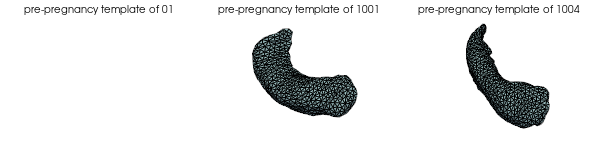

In [8]:
pl = pv.Plotter(shape=(1,3), border=False, window_size=[600, 150])

# First subplot empty
pl.subplot(0,0)
pl.add_text("pre-pregnancy template of 01", position='upper_edge', font_size=4)

# Second subplot - template 1001
pl.subplot(0,1)
pl.add_mesh(templates["1001"], show_edges=True)
pl.add_text("pre-pregnancy template of 1001", position='upper_edge', font_size=4)

# Third subplot - template 1004 
pl.subplot(0,2)
pl.add_mesh(templates["1004"], show_edges=True)
pl.add_text("pre-pregnancy template of 1004", position='upper_edge', font_size=4)

pl.show()

In [9]:
# compute global prepregnancy control deterministic atlas

templates["global"] = None

meshes_writer = Map(PvWriter(dirname=OUTPUTS_DIR, ext="vtk"))

mesh_filenames = meshes_writer(
    [(f"template_{index}", mesh) for index, mesh in enumerate([templates["1001"], templates["1004"]])]
)
dataset = [{"shape": filename} for filename in mesh_filenames]
kernel_width = 10  # NB: influences the number of cp
registration_kwargs = dict(
    kernel_width=kernel_width,
    regularisation=1,
    max_iter=2000,
    freeze_control_points=False,
    metric="varifold",
    attachment_kernel_width=2.0,
    tol=1e-10,
    # filter_cp=True,
    # threshold=0.75,
)


lddmm.estimate_deterministic_atlas(
    dataset[0]["shape"],
    dataset,
    "structure",
    ATLAS_DIR,
    initial_step_size=1e-1,
    **registration_kwargs,
)
templates["global"] = PvReader()(ATLAS_DIR / lddmm_strings.template_str)

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 128
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/atlas_example/atlas/deformetrica-state.p.
>> Removing the pre-existing state file with same path.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
{'max_iterations': 2000, 'freeze_template': False, 'freeze_control_points': False, 'freeze_momenta': False, 'use_sobolev_gradient': True, 'sobolev_kernel_width_ratio': 1, 'max_line_search_iterations': 50, 'initial_control_points': None, 'initial_cp_spacing': None, 'initial_momenta': None, 'dense_mode': False, 'number_of_threads': 1, 'print_every_n_iters': 20, 'downsampling_factor': 1, 'dimension': 3, 'optimization_metho

/home/nmiolane/anaconda3/envs/polpo/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


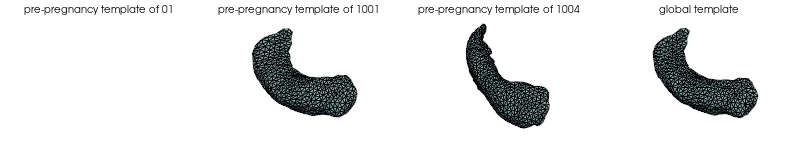

In [10]:
pl = pv.Plotter(shape=(1,4), border=False, window_size=[800, 150])

# First subplot empty
pl.subplot(0,0)
pl.add_text("pre-pregnancy template of 01", position='upper_edge', font_size=4)

# Second subplot - template 1001
pl.subplot(0,1)
pl.add_mesh(templates["1001"], show_edges=True)
pl.add_text("pre-pregnancy template of 1001", position='upper_edge', font_size=4)

# Third subplot - template 1004 
pl.subplot(0,2)
pl.add_mesh(templates["1004"], show_edges=True)
pl.add_text("pre-pregnancy template of 1004", position='upper_edge', font_size=4)

# Fourth subplot - global template
pl.subplot(0,3)
pl.add_mesh(templates["global"], show_edges=True)
pl.add_text("global template", position='upper_edge', font_size=4)

pl.show()

In [11]:
# compute the deformation between the pre-pregnancy template of 01 and each mesh of 1001.
# one idea is to directly compute the difference, but it woujdn't use the control points
REGISTRATION_DIR = OUTPUTS_DIR / "registration"

registration_kwargs = dict(
    kernel_width=kernel_width,
    regularisation=1,
    max_iter=2000,
    freeze_control_points=False,
    metric="varifold",
    #attachment_kernel_width=2.0,
    tol=1e-10,
    # filter_cp=True,
    # threshold=0.75,
)

momenta_from_subject_template = {
    "01": [],
    "1001": [],
    "1004": [],
}

# This take 4 minutes
for subject_id in ["1001", "1004"]:
    for mesh in meshes[subject_id]:  # HACK FOR DEBUGGING
        mesh_filenames = meshes_writer(
        [(f"template_{index}", mesh) for index, mesh in enumerate([templates["1001"], mesh])]
    )
        lddmm.registration.estimate_registration(
            mesh_filenames[0],  #template 
            mesh_filenames[1],
            output_dir=REGISTRATION_DIR,
            **registration_kwargs,
        )
        momenta_from_subject_template[subject_id].append(read_3D_array(REGISTRATION_DIR / lddmm_strings.momenta_str))

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 128
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/atlas_example/registration/deformetrica-state.p.
>> Removing the pre-existing state file with same path.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
>> Set of 24 control points defined.
>> Momenta initialized to zero, for 1 subjects.
dtype=float32
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------

------------------------------------- Iteration: 20 -------------------------------------
>> Log-likelihood = -1.437E+01 	 [ attachment = -1.294E+01 ;

In [12]:
csv["1001"]["gestWeek"]

sessionID
base1   -18.0
base2   -13.0
gest1     8.0
gest2    13.0
gest3    17.0
gest4    22.0
gest5    26.0
gest6    30.0
gest7    35.0
post1    43.0
post2    48.0
post3    56.0
post4    65.0
Name: gestWeek, dtype: float64

In [13]:
csv["1001"]

,gestWeek,stage,trimester,date
sessionID,,,,
base1,-18.0,pre,pre,4/1/2023
base2,-13.0,pre,pre,5/6/2023
gest1,8.0,preg,first,9/30/2023
gest2,13.0,preg,first,11/4/2023
gest3,17.0,preg,second,12/2/2023
gest4,22.0,preg,second,1/6/2024
gest5,26.0,preg,second,2/3/2024
gest6,30.0,preg,third,3/2/2024
gest7,35.0,preg,third,4/6/2024


In [14]:
from sklearn.linear_model import LinearRegression

X = []
y = []

for subject_id in ["1001", "1004"]:
    # Get pregnancy indices from CSV files
    subject_csv = csv[subject_id]
    subject_momenta = momenta_from_subject_template[subject_id]
    assert len(subject_momenta) == len(subject_csv)
    pregnancy_indices = subject_csv.reset_index().index[subject_csv["stage"] == "preg"]
    # Select corresponding pre-pregnancy meshes
    pregnancy_momenta  = [subject_momenta[i] for i in pregnancy_indices]
    pregnancy_gestweek = subject_csv["gestWeek"][subject_csv["stage"] == "preg"].tolist()
    assert len(pregnancy_gestweek) == len(pregnancy_momenta)
    print(f"Found {len(pregnancy_momenta)} pregnancy momenta")
    y.extend(pregnancy_gestweek)
    X.extend(pregnancy_momenta)


X = np.array(X).reshape(len(y), -1)
y = np.array(y)

# Standardize y to have zero mean and unit variance
y = (y - np.mean(y)) / np.std(y)


print(X.shape)
print(y.shape)

Found 7 pregnancy momenta
Found 14 pregnancy momenta
(21, 72)
(21,)


In [15]:
# Train-test split and regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regression = LinearRegression()
regression.fit(X_train, y_train)

train_r2 = regression.score(X_train, y_train)
test_r2 = regression.score(X_test, y_test)

print(f"Regression coefficients: {regression.coef_}")
print(f"Regression intercept: {regression.intercept_}")
print(f"Train R2 score: {train_r2:.3f}")
print(f"Test R2 score: {test_r2:.3f}")


Regression coefficients: [-0.14088093 -0.14503729 -0.05823957 -0.44364251 -0.19836032  0.20790951
  0.16566195  0.13945593  0.01718644  0.24658284  0.00079186 -0.05361605
 -0.08783108  0.00803977 -0.18113416 -0.19322688  0.06092284  0.00848649
  0.04810469 -0.11117479 -0.09489521 -0.0772966   0.15970722  0.15410101
  0.11540806  0.1228356  -0.05969076  0.11346242 -0.10269639  0.08797248
  0.03966009  0.11850876 -0.12445094  0.06951599 -0.08226043  0.12307819
  0.17351697 -0.17218707  0.11717095 -0.03800912  0.0645598  -0.01958786
  0.00432534 -0.10334666 -0.06173538  0.10098247  0.04067179 -0.02235138
 -0.02960097  0.01161269  0.11851573 -0.04245422  0.01052365 -0.19047024
  0.06268366 -0.08721963 -0.13932477  0.22966053 -0.19754163 -0.09648834
 -0.22614301  0.06707547 -0.01545652  0.13014465 -0.14438466  0.09431858
  0.00887758 -0.03437278  0.20247312  0.14633573 -0.17451262 -0.12296802]
Regression intercept: 0.8777751599104278
Train R2 score: 1.000
Test R2 score: -1.815
